
 [시계열 특성 추출: 이동 평균과 윈도우]에 대한 상세 강의 자료와 실습 노트북이다.

이 시간의 핵심은 "데이터를 통째로 보는 것이 아니라, 작은 창문(Window)을 통해 부분부분 훑어보며 패턴을 찾아내는 방법"을 배우는 것이다. 헬스케어 모니터링 시스템(알람)의 기본 원리가 되는 매우 중요한 파트이다.

---

# 📘 시계열의 노이즈 제거와 패턴 찾기

## 1. 신호(Signal)와 소음(Noise)
*   헬스케어 데이터의 현실: 환자의 생체 신호는 절대 깨끗하지 않다. 환자가 기침을 하거나, 몸을 뒤척이거나, 센서가 흔들리면 수치가 일시적으로 튄다. 이것을 소음(Noise)이라고 한다.
*   분석가의 목표: 소음을 걸러내고 환자의 진짜 상태인 신호(Signal)나 추세(Trend)를 찾아내는 것이다.

## 2. 이동 평균 (Moving Average)과 롤링 윈도우 (Rolling Window)
이동 평균은 가장 대표적인 '노이즈 제거' 기법이다.

*   원리:
    1.  데이터 위에 일정한 크기의 '창문(Window)'을 올려놓는다. (예: 5분짜리 창문)
    2.  창문 안에 들어온 데이터들의 평균을 구한다.
    3.  창문을 오른쪽(시간 순서)으로 한 칸씩 민다(Rolling).
    4.  이 과정을 끝까지 반복한다.
*   효과: 들쑥날쑥하던 그래프가 부드러운 곡선(Smoothing)으로 변한다. 튀는 값들이 평균에 묻혀 희석되기 때문이다.

## 3. 다양한 롤링 통계 (Rolling Statistics)
창문(Window) 안에서 꼭 '평균'만 구할 필요는 없다. 목적에 따라 다른 계산을 한다.

1.  이동 표준편차 (Rolling Standard Deviation):
    *   창문 내 데이터가 얼마나 흔들리는지를 계산한다.
    *   *활용:* "변동성(Volatility)" 측정. 환자의 혈압이 안정적인지, 아니면 급격히 오르락내리락하는지(불안정)를 수치화할 때 쓴다.
2.  이동 최대/최소 (Rolling Max/Min):
    *   창문 내에서의 최고/최저값을 찾는다.
    *   *활용:* 지난 1시간 동안의 최고 체온은 얼마였나?

## 4. 시차(Lag)와 차분(Difference)
"어제보다 오늘 얼마나 아픈가?"를 계산하는 방법이다.

*   Shift (시차): 데이터를 한 칸씩 뒤로 미룬다. (오늘 날짜 옆에 어제 데이터를 붙일 때 사용)
*   Diff (차분): `오늘 데이터 - 어제 데이터`를 계산한다.
    *   *활용:* 변화량 감지. 갑자기 심박수가 +20 상승한 시점을 찾아낼 때 유용하다.

---
---

# 💻움직이는 창문으로 패턴 찾기 (Rolling & Diff)

이 노트북에서는 노이즈가 심한 가상의 심박수 데이터를 생성하고, 이동 평균을 통해 추세를 파악하며, 이동 표준편차를 통해 환자의 상태 변화(불안정성)를 감지해본다.

### 1. 환경 설정 및 노이즈 데이터 생성
점점 상승하는 추세를 가졌지만, 측정 오차(노이즈)가 심하게 섞인 심박수 데이터를 만든다.

데이터 미리보기:


,Heart_Rate
Time(min),
0,64.967142
1,59.122407
2,67.486986
3,76.745450
4,59.678668


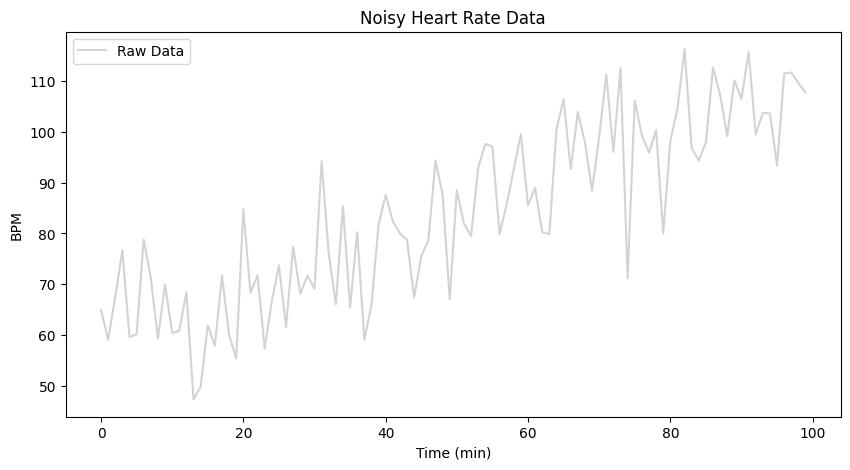

In [1]:
!pip install pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성: 100분 동안의 심박수 (1분 간격)
np.random.seed(42)
minutes = np.arange(0, 100)

# 1. 기본 추세 (Trend): 시간이 갈수록 심박수가 서서히 오름 (60 -> 110)
trend = np.linspace(60, 110, 100)

# 2. 노이즈 (Noise): 환자의 움직임 등으로 인한 측정 오차 (+- 10 범위)
noise = np.random.normal(0, 10, 100)

# 3. 최종 데이터: 추세 + 노이즈
heart_rate = trend + noise

# 데이터프레임 생성
df = pd.DataFrame({'Heart_Rate': heart_rate}, index=minutes)
df.index.name = 'Time(min)'

print("데이터 미리보기:")
display(df.head())

# 시각화: 원본 데이터 확인
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Heart_Rate'], label='Raw Data', color='lightgray', linewidth=1.5)
plt.title("Noisy Heart Rate Data")
plt.xlabel("Time (min)")
plt.ylabel("BPM")
plt.legend()
plt.show()

# 해석: 회색 선이 매우 지저분해서, 실제로 심박수가 오르고 있는지 한눈에 확신하기 어렵다.

### 2. 이동 평균 (Rolling Mean)으로 추세선 그리기
`rolling(window=n)` 함수를 사용한다. `window=10`은 "지난 10분간의 평균"을 의미한다.

이동 평균 계산 결과 (원본 vs 이동평균):


,Heart_Rate,MA_10
Time(min),,
0,64.967142,64.967142
1,59.122407,62.044775
2,67.486986,63.858845
3,76.745450,67.080496
4,59.678668,65.600131
5,60.183883,64.697423
6,78.822431,66.715281
7,71.209701,67.277084
8,59.345660,66.395814


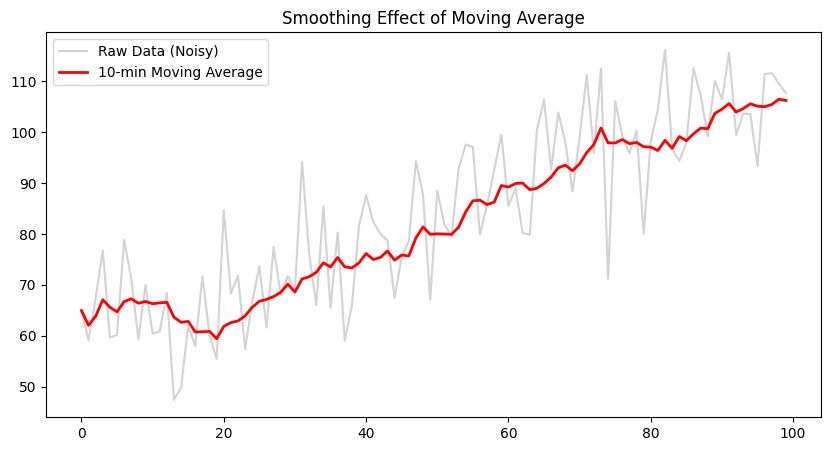

In [2]:
# 10분 이동 평균 계산 (Smoothing)
# min_periods=1 옵션: 데이터가 10개가 안 모인 초반부에도 평균을 구하도록 설정
df['MA_10'] = df['Heart_Rate'].rolling(window=10, min_periods=1).mean()

# 결과 확인
print("이동 평균 계산 결과 (원본 vs 이동평균):")
display(df[['Heart_Rate', 'MA_10']].head(12))

# 시각화 비교
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Heart_Rate'], label='Raw Data (Noisy)', color='lightgray')
plt.plot(df.index, df['MA_10'], label='10-min Moving Average', color='red', linewidth=2)

plt.title("Smoothing Effect of Moving Average")
plt.legend()
plt.show()

# 해석: 빨간 선(이동 평균)을 보면, 자잘한 노이즈는 사라지고 "심박수가 우상향하고 있다"는 추세가 명확히 보인다.

### 3. 이동 표준편차 (Rolling Std)로 변동성 측정하기
환자의 상태가 급변하는 구간이나, 센서가 불안정한 구간을 찾는다.

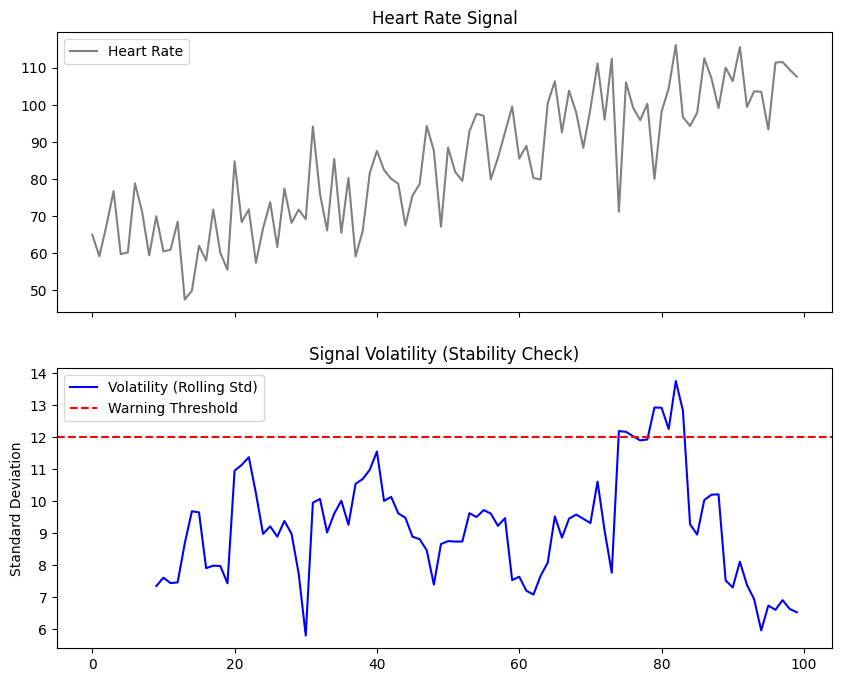

In [3]:
# 10분 이동 표준편차 계산
df['Volatility'] = df['Heart_Rate'].rolling(window=10).std()

# 시각화: 심박수와 변동성을 위아래로 나누어 그리기
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 위쪽 그래프: 심박수
ax[0].plot(df.index, df['Heart_Rate'], label='Heart Rate', color='gray')
ax[0].set_title('Heart Rate Signal')
ax[0].legend()

# 아래쪽 그래프: 변동성
ax[1].plot(df.index, df['Volatility'], label='Volatility (Rolling Std)', color='blue')
ax[1].set_title('Signal Volatility (Stability Check)')
ax[1].set_ylabel('Standard Deviation')
ax[1].axhline(y=12, color='red', linestyle='--', label='Warning Threshold') # 임계값 예시
ax[1].legend()

plt.show()

# 해석: 파란 선이 높게 치솟는 구간은 환자의 심박수가 그 10분 동안 널뛰기를 했다는 뜻이다.
# 의료진에게 "상태 불안정 알람"을 보낼 때 이 지표를 사용한다.

### 4. 차분 (Diff)을 이용한 급격한 변화 감지
이전 시점과 비교하여 값이 얼마나 변했는지를 계산한다.

급격한 변화가 감지된 시점 (Threshold >= 15):


,Heart_Rate,MA_10,Volatility,Change
Time(min),,,,
4,59.678668,65.600131,NaN,-17.066782
6,78.822431,66.715281,NaN,18.638548
13,47.432854,63.643907,8.679321,-21.047375
20,84.757498,61.850767,10.949329,29.284575
21,68.348298,62.595771,11.129293,-16.409200
27,77.393344,67.717205,9.379772,15.771966
31,94.179348,71.176102,9.947781,25.044898
32,76.026644,71.600127,10.066350,-18.152704
34,85.397166,74.344193,9.606946,19.307609


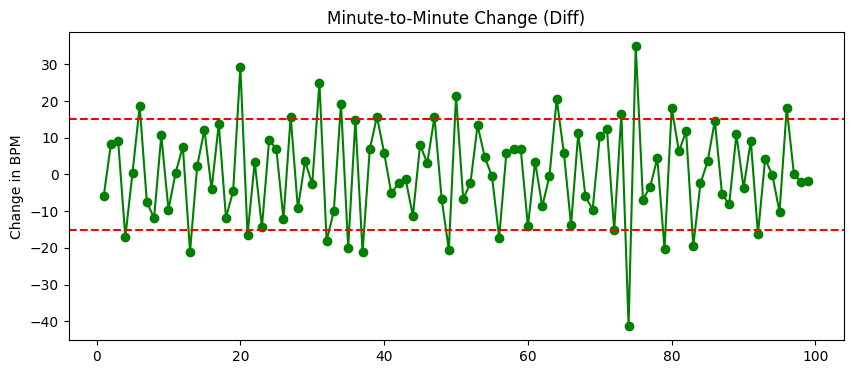

In [4]:
# 1분 전 대비 변화량 계산
df['Change'] = df['Heart_Rate'].diff() # 기본값은 1 (바로 윗 행과 비교)

# 변화량이 급격한 순간 찾기 (예: 1분 만에 15 이상 오르거나 내린 경우)
threshold = 15
sudden_changes = df[abs(df['Change']) >= threshold]

print(f"급격한 변화가 감지된 시점 (Threshold >= {threshold}):")
display(sudden_changes)

# 시각화
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Change'], color='green', marker='o', linestyle='-')
plt.axhline(y=threshold, color='red', linestyle='--')
plt.axhline(y=-threshold, color='red', linestyle='--')
plt.title("Minute-to-Minute Change (Diff)")
plt.ylabel("Change in BPM")
plt.show()

### 📝 실습 과제
생성된 데이터프레임 `df`를 이용하여 다음을 수행한다.

1.  30분 이동 평균(`MA_30`)을 추가로 계산한다.
2.  기존의 `MA_10`(단기 추세)과 `MA_30`(장기 추세)을 하나의 그래프에 겹쳐 그린다.
3.  골든 크로스(Golden Cross) 개념 적용: 단기 추세선이 장기 추세선을 뚫고 올라가는 지점이 있는지 눈으로 확인해본다. (주식뿐만 아니라 환자 상태가 급격히 악화/호전되는 전환점을 찾을 때도 쓰이는 개념이다.)

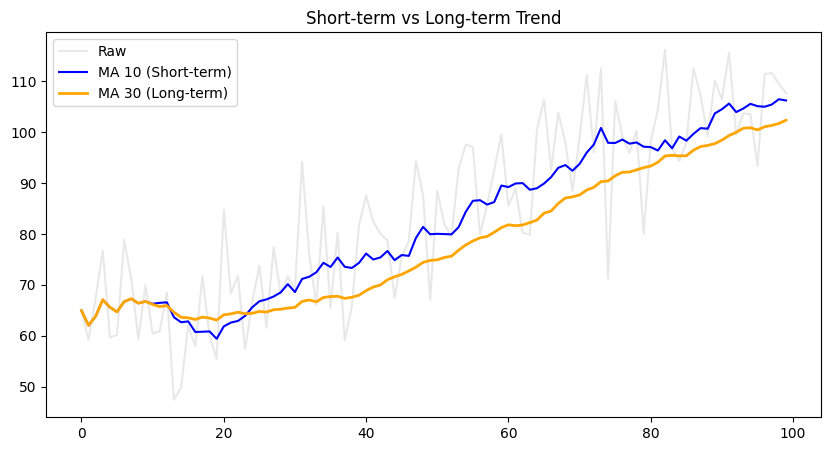

In [5]:
# [실습 답안 예시]

# 1. 30분 이동 평균 계산
df['MA_30'] = df['Heart_Rate'].rolling(window=30, min_periods=1).mean()

# 2. 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Heart_Rate'], label='Raw', color='lightgray', alpha=0.5)
plt.plot(df.index, df['MA_10'], label='MA 10 (Short-term)', color='blue')
plt.plot(df.index, df['MA_30'], label='MA 30 (Long-term)', color='orange', linewidth=2)

plt.title("Short-term vs Long-term Trend")
plt.legend()
plt.show()

# 해석: 파란선(단기)이 주황선(장기)보다 위에 있다는 것은 최근 상태가 과거 평균보다 높다는 뜻이다.
# 즉, 심박수가 계속 상승 중임을 나타낸다.